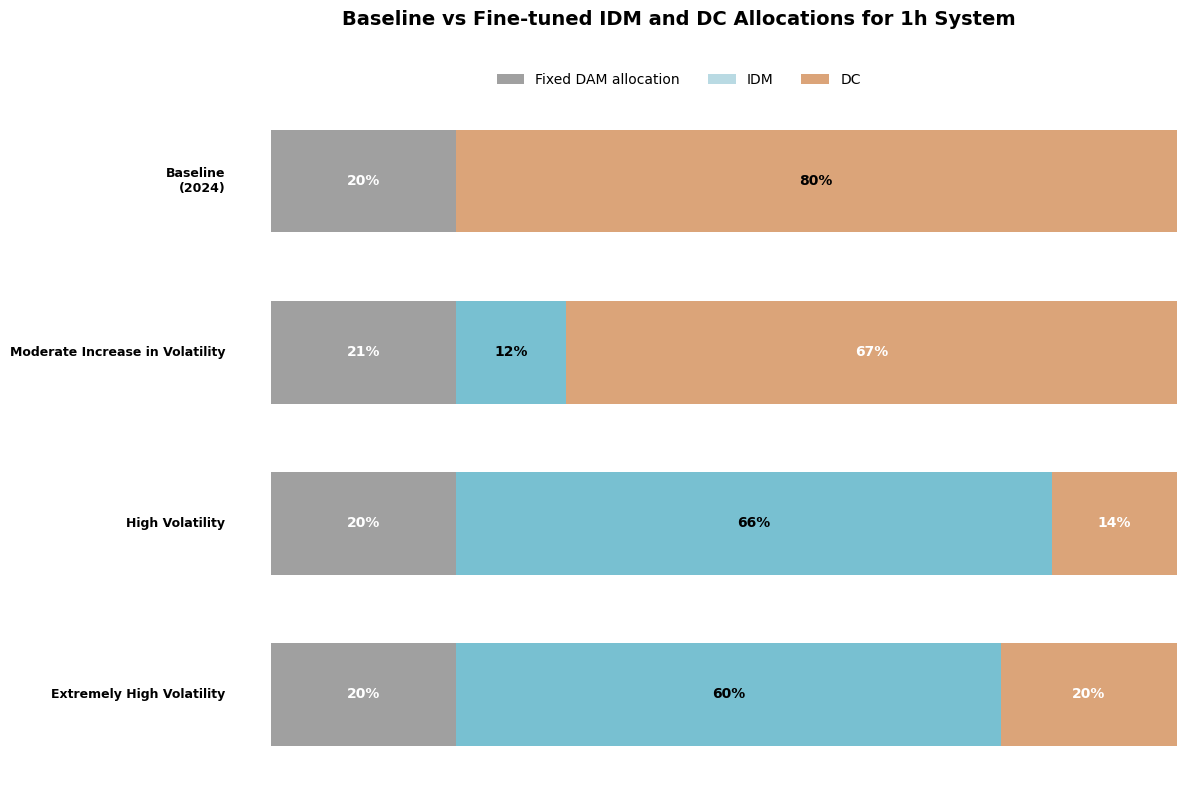

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def round_percentages(values):
    """Round percentages to sum to 100%"""
    # Convert to percentages and round
    percentages = [v * 100 for v in values]
    rounded = [round(p) for p in percentages]
    
    # Adjust for rounding errors
    diff = 100 - sum(rounded)
    if diff != 0:
        # Find the value with largest fractional part to adjust
        fractional_parts = [p - round(p) for p in percentages]
        if diff > 0:
            # Need to add - find largest positive fractional part
            max_idx = fractional_parts.index(max(fractional_parts))
            rounded[max_idx] += diff
        else:
            # Need to subtract - find largest negative fractional part  
            min_idx = fractional_parts.index(min(fractional_parts))
            rounded[min_idx] += diff
    
    return rounded

# Load data and calculate duration
data_2024 = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Figure_12_Model_Outputs/figure_12_2024.csv')
# Filter for 1-hour duration and risk_aversion = 3
data_1h = data_2024[(data_2024['energy_mwh'] / data_2024['power_mw'] == 1.0) & (data_2024['risk_aversion'] == 3.0)]

# Get allocation data
baseline_dam = data_1h['baseline_dam_weight'].mean()
baseline_idm = data_1h['baseline_idm_weight'].mean()
baseline_dc = data_1h['baseline_dc_weight'].mean()

# Scenario allocations (scaled to remaining capacity)
remaining_cap = 1 - baseline_dam
# Reordered scenarios: 2023 first, then 2021, then 2022
scenarios = ['2023', '2021', '2022']
scenario_labels = ['Moderate Increase in Volatility', 'High Volatility', 'Extremely High Volatility']
scenario_data = {}

for scenario in scenarios:
    idm_weight = data_1h[f'updated_{scenario}_idm_weight'].mean() * remaining_cap
    dc_weight = data_1h[f'updated_{scenario}_dc_weight'].mean() * remaining_cap
    scenario_data[scenario] = {'IDM': idm_weight, 'DC': dc_weight}

# Create figure with better proportions
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Original colors from EDA for D* price level
base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#d38d5763'}
colors_grey = {'DAM': '#888888'}  # Grey for all DAM allocations

# Define separate y positions for baseline and cases
baseline_y = 0.7
case_positions = [0.5, 0.3, 0.1]  # Separate from baseline
bar_height = 0.12

# Baseline bar - DAM now in grey as well
ax.barh(baseline_y, baseline_dam, bar_height, left=0, color=colors_grey['DAM'], alpha=0.8, label='Fixed DAM allocation')
ax.barh(baseline_y, baseline_idm, bar_height, left=baseline_dam, color=light_colors['IDM'], alpha=0.8, label='IDM')
ax.barh(baseline_y, baseline_dc, bar_height, left=baseline_dam+baseline_idm, color=light_colors['DC'], alpha=0.8, label='DC')

# Round baseline percentages to sum to 100%
baseline_values = [baseline_dam, baseline_idm, baseline_dc]
baseline_rounded = round_percentages(baseline_values)

# Add percentage labels to baseline (skip if 0%)
if baseline_rounded[0] > 5:  # Show if > 5%
    ax.text(baseline_dam/2, baseline_y, f'{baseline_rounded[0]}%', ha='center', va='center', fontweight='bold', color='white', fontsize=10)
if baseline_rounded[1] > 1:  # Show if > 1%
    ax.text(baseline_dam + baseline_idm/2, baseline_y, f'{baseline_rounded[1]}%', ha='center', va='center', fontweight='bold', fontsize=10)
if baseline_rounded[2] > 1:  # Show if > 1%
    ax.text(baseline_dam + baseline_idm + baseline_dc/2, baseline_y, f'{baseline_rounded[2]}%', ha='center', va='center', fontweight='bold', fontsize=10)

# Case bars (completely separate positions) - DAM in grey for scenarios
for i, (scenario, label) in enumerate(zip(scenarios, scenario_labels)):
    y_pos = case_positions[i]
    idm_val = scenario_data[scenario]['IDM']
    dc_val = scenario_data[scenario]['DC']
    
    # DAM portion (grey for scenario cases)
    ax.barh(y_pos, baseline_dam, bar_height, left=0, color=colors_grey['DAM'], alpha=0.8)
    # IDM portion (base color)
    ax.barh(y_pos, idm_val, bar_height, left=baseline_dam, color=base_colors['IDM'], alpha=0.8)
    # DC portion (base color)
    ax.barh(y_pos, dc_val, bar_height, left=baseline_dam + idm_val, color=base_colors['DC'], alpha=0.8)
    
    # Add case labels on the left with new volatility labels
    ax.text(-0.05, y_pos, label, ha='right', va='center', fontweight='bold', fontsize=9)
    
    # Round case percentages to sum to 100%
    case_values = [baseline_dam, idm_val, dc_val]
    case_rounded = round_percentages(case_values)
    
    # Add percentage labels (skip 0% labels)
    if case_rounded[0] > 5:  # Show if > 5%
        ax.text(baseline_dam/2, y_pos, f'{case_rounded[0]}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    if case_rounded[1] > 1:  # Only show if > 1%
        ax.text(baseline_dam + idm_val/2, y_pos, f'{case_rounded[1]}%', ha='center', va='center', fontsize=10, fontweight='bold')
    if case_rounded[2] > 1:  # Only show if > 1%
        ax.text(baseline_dam + idm_val + dc_val/2, y_pos, f'{case_rounded[2]}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Add baseline label
ax.text(-0.05, baseline_y, 'Baseline\n(2024)', ha='right', va='center', fontweight='bold', fontsize=9)

# Clean formatting
ax.set_xlim(-0.1, 1)
ax.set_ylim(0, 0.85)  # Adjusted for new baseline position
ax.set_title('Baseline vs Fine-tuned IDM and DC Allocations for 1h System', fontsize=14, fontweight='bold', pad=20)

# Remove all axes
ax.set_xticks([])
ax.set_yticks([])

# Add legend positioned closer to title but further from bars
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, frameon=False)

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

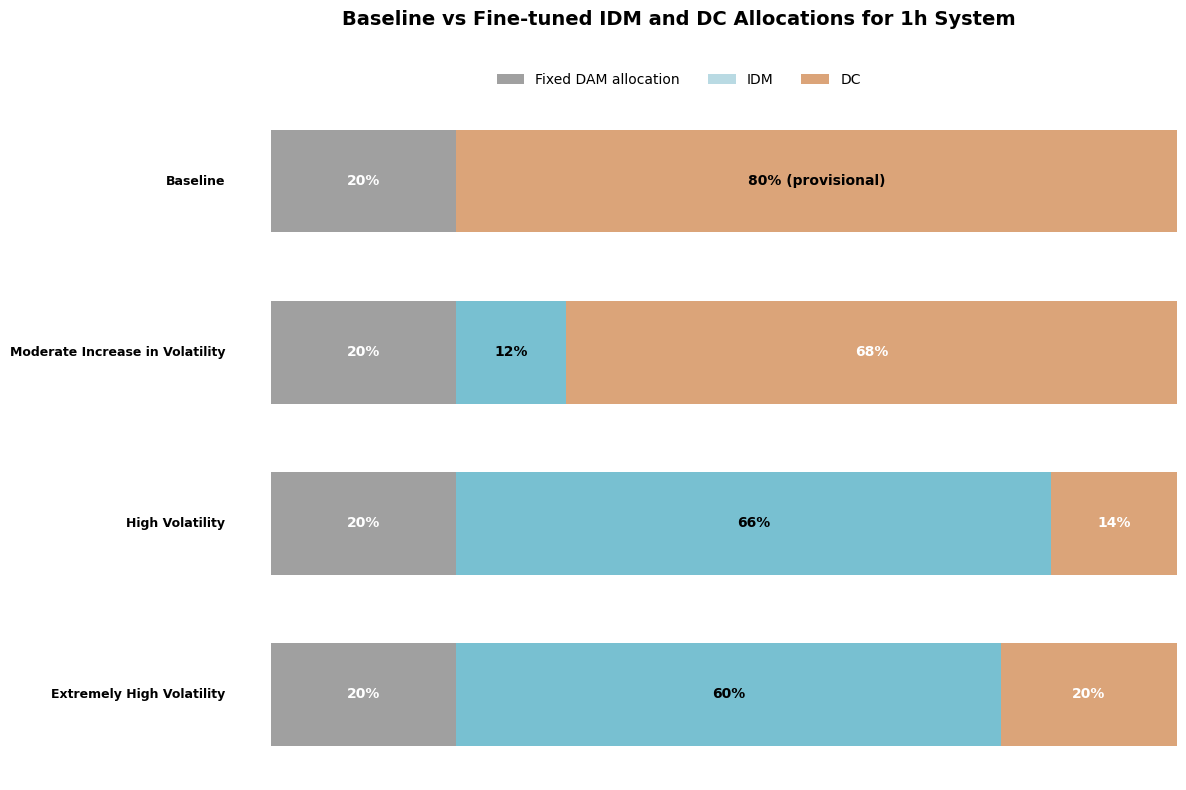

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def round_percentages(values):
    """Round percentages to sum to 100%"""
    # Convert to percentages and round
    percentages = [v * 100 for v in values]
    rounded = [round(p) for p in percentages]
    
    # Adjust for rounding errors
    diff = 100 - sum(rounded)
    if diff != 0:
        # Find the value with largest fractional part to adjust
        fractional_parts = [p - round(p) for p in percentages]
        if diff > 0:
            # Need to add - find largest positive fractional part
            max_idx = fractional_parts.index(max(fractional_parts))
            rounded[max_idx] += diff
        else:
            # Need to subtract - find largest negative fractional part  
            min_idx = fractional_parts.index(min(fractional_parts))
            rounded[min_idx] += diff
    
    return rounded

# Load data and get 1-hour duration results
data_2024 = pd.read_csv('Results for EDA/2024 results.csv')
data_1h = data_2024[data_2024['Duration'] == 1.0]

# Get allocation data
baseline_dam = data_1h['baseline_dam_weight'].mean()
baseline_idm = data_1h['baseline_idm_weight'].mean()
baseline_dc = data_1h['baseline_dc_weight'].mean()

# Scenario allocations (scaled to remaining capacity)
remaining_cap = 1 - baseline_dam
# Reordered scenarios: 2023 first, then 2021, then 2022
scenarios = ['2023', '2021', '2022']
scenario_labels = ['Moderate Increase in Volatility', 'High Volatility', 'Extremely High Volatility']
scenario_data = {}

for scenario in scenarios:
    idm_weight = data_1h[f'updated_{scenario}_idm_weight'].mean() * remaining_cap
    dc_weight = data_1h[f'updated_{scenario}_dc_weight'].mean() * remaining_cap
    scenario_data[scenario] = {'IDM': idm_weight, 'DC': dc_weight}

# Create figure with better proportions
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Original colors from EDA for D* price level
base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#d38d5763'}
colors_grey = {'DAM': '#888888'}  # Grey for all DAM allocations

# Define separate y positions for baseline and cases
baseline_y = 0.7
case_positions = [0.5, 0.3, 0.1]  # Separate from baseline
bar_height = 0.12

# Baseline bar - DAM now in grey as well
ax.barh(baseline_y, baseline_dam, bar_height, left=0, color=colors_grey['DAM'], alpha=0.8, label='Fixed DAM allocation')
ax.barh(baseline_y, baseline_idm, bar_height, left=baseline_dam, color=light_colors['IDM'], alpha=0.8, label='IDM')
ax.barh(baseline_y, baseline_dc, bar_height, left=baseline_dam+baseline_idm, color=light_colors['DC'], alpha=0.8, label='DC')

# Round baseline percentages to sum to 100%
baseline_values = [baseline_dam, baseline_idm, baseline_dc]
baseline_rounded = round_percentages(baseline_values)

# Add percentage labels to baseline (skip if 0%) with "(provisional)" for IDM and DC
if baseline_rounded[0] > 5:  # Show if > 5%
    ax.text(baseline_dam/2, baseline_y, f'{baseline_rounded[0]}%', ha='center', va='center', fontweight='bold', color='white', fontsize=10)
if baseline_rounded[1] > 1:  # Show if > 1%
    ax.text(baseline_dam + baseline_idm/2, baseline_y, f'{baseline_rounded[1]}% (provisional)', ha='center', va='center', fontweight='bold', fontsize=10)
if baseline_rounded[2] > 1:  # Show if > 1%
    ax.text(baseline_dam + baseline_idm + baseline_dc/2, baseline_y, f'{baseline_rounded[2]}% (provisional)', ha='center', va='center', fontweight='bold', fontsize=10)

# Case bars (completely separate positions) - DAM in grey for scenarios
for i, (scenario, label) in enumerate(zip(scenarios, scenario_labels)):
    y_pos = case_positions[i]
    idm_val = scenario_data[scenario]['IDM']
    dc_val = scenario_data[scenario]['DC']
    
    # DAM portion (grey for scenario cases)
    ax.barh(y_pos, baseline_dam, bar_height, left=0, color=colors_grey['DAM'], alpha=0.8)
    # IDM portion (base color)
    ax.barh(y_pos, idm_val, bar_height, left=baseline_dam, color=base_colors['IDM'], alpha=0.8)
    # DC portion (base color)
    ax.barh(y_pos, dc_val, bar_height, left=baseline_dam + idm_val, color=base_colors['DC'], alpha=0.8)
    
    # Add case labels on the left with new volatility labels
    ax.text(-0.05, y_pos, label, ha='right', va='center', fontweight='bold', fontsize=9)
    
    # Round case percentages to sum to 100%
    case_values = [baseline_dam, idm_val, dc_val]
    case_rounded = round_percentages(case_values)
    
    # Add percentage labels (skip 0% labels)
    if case_rounded[0] > 5:  # Show if > 5%
        ax.text(baseline_dam/2, y_pos, f'{case_rounded[0]}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    if case_rounded[1] > 1:  # Only show if > 1%
        ax.text(baseline_dam + idm_val/2, y_pos, f'{case_rounded[1]}%', ha='center', va='center', fontsize=10, fontweight='bold')
    if case_rounded[2] > 1:  # Only show if > 1%
        ax.text(baseline_dam + idm_val + dc_val/2, y_pos, f'{case_rounded[2]}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Add baseline label
ax.text(-0.05, baseline_y, 'Baseline', ha='right', va='center', fontweight='bold', fontsize=9)

# Clean formatting
ax.set_xlim(-0.1, 1)
ax.set_ylim(0, 0.85)  # Adjusted for new baseline position
ax.set_title('Baseline vs Fine-tuned IDM and DC Allocations for 1h System', fontsize=14, fontweight='bold', pad=20)

# Remove all axes
ax.set_xticks([])
ax.set_yticks([])

# Add legend positioned closer to title but further from bars
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, frameon=False)

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

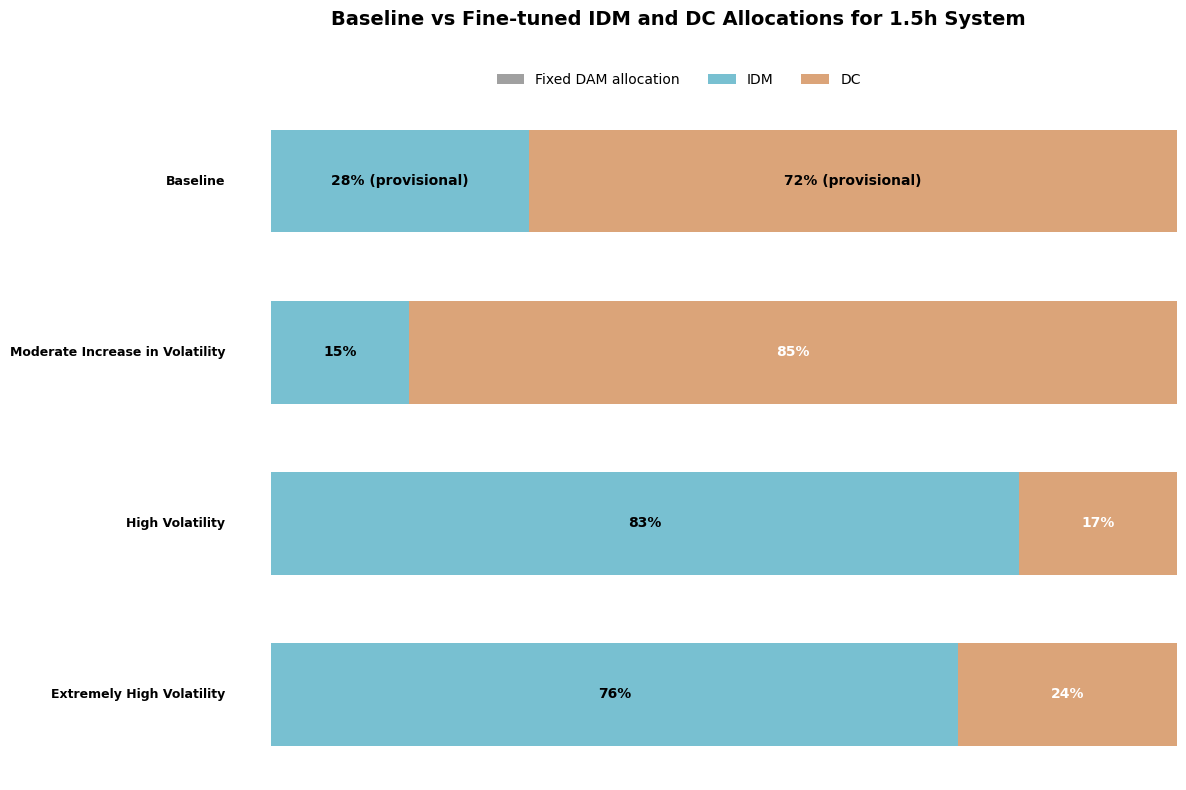

In [8]:
'''1.5 hour analysis'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def round_percentages(values):
    """Round percentages to sum to 100%"""
    # Convert to percentages and round
    percentages = [v * 100 for v in values]
    rounded = [round(p) for p in percentages]
    
    # Adjust for rounding errors
    diff = 100 - sum(rounded)
    if diff != 0:
        # Find the value with largest fractional part to adjust
        fractional_parts = [p - round(p) for p in percentages]
        if diff > 0:
            # Need to add - find largest positive fractional part
            max_idx = fractional_parts.index(max(fractional_parts))
            rounded[max_idx] += diff
        else:
            # Need to subtract - find largest negative fractional part  
            min_idx = fractional_parts.index(min(fractional_parts))
            rounded[min_idx] += diff
    
    return rounded

# Load data and calculate duration
data_2024 = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Figure_12_Model_Outputs/figure_12_2024.csv')
# Filter for 1.5-hour duration and risk_aversion = 3
data_1_5h = data_2024[(data_2024['energy_mwh'] / data_2024['power_mw'] == 1.5) & (data_2024['risk_aversion'] == 3.0)]

# Get allocation data
baseline_dam = data_1_5h['baseline_dam_weight'].mean()
baseline_idm = data_1_5h['baseline_idm_weight'].mean()
baseline_dc = data_1_5h['baseline_dc_weight'].mean()

# Scenario allocations (scaled to remaining capacity)
remaining_cap = 1 - baseline_dam
# Reordered scenarios: 2023 first, then 2021, then 2022
scenarios = ['2023', '2021', '2022']
scenario_labels = ['Moderate Increase in Volatility', 'High Volatility', 'Extremely High Volatility']
scenario_data = {}

for scenario in scenarios:
    idm_weight = data_1_5h[f'updated_{scenario}_idm_weight'].mean() * remaining_cap
    dc_weight = data_1_5h[f'updated_{scenario}_dc_weight'].mean() * remaining_cap
    scenario_data[scenario] = {'IDM': idm_weight, 'DC': dc_weight}

# Create figure with better proportions
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Original colors from EDA for D* price level
base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
light_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
colors_grey = {'DAM': '#888888'}  # Grey for all DAM allocations

# Define separate y positions for baseline and cases
baseline_y = 0.7
case_positions = [0.5, 0.3, 0.1]  # Separate from baseline
bar_height = 0.12

# Baseline bar - DAM now in grey as well
ax.barh(baseline_y, baseline_dam, bar_height, left=0, color=colors_grey['DAM'], alpha=0.8, label='Fixed DAM allocation')
ax.barh(baseline_y, baseline_idm, bar_height, left=baseline_dam, color=light_colors['IDM'], alpha=0.8, label='IDM')
ax.barh(baseline_y, baseline_dc, bar_height, left=baseline_dam+baseline_idm, color=light_colors['DC'], alpha=0.8, label='DC')

# Round baseline percentages to sum to 100%
baseline_values = [baseline_dam, baseline_idm, baseline_dc]
baseline_rounded = round_percentages(baseline_values)

# Add percentage labels to baseline (skip if 0%) with "(provisional)" for IDM and DC
if baseline_rounded[0] > 5:  # Show if > 5%
    ax.text(baseline_dam/2, baseline_y, f'{baseline_rounded[0]}%', ha='center', va='center', fontweight='bold', color='white', fontsize=10)
if baseline_rounded[1] > 1:  # Show if > 1%
    ax.text(baseline_dam + baseline_idm/2, baseline_y, f'{baseline_rounded[1]}% (provisional)', ha='center', va='center', fontweight='bold', fontsize=10)
if baseline_rounded[2] > 1:  # Show if > 1%
    ax.text(baseline_dam + baseline_idm + baseline_dc/2, baseline_y, f'{baseline_rounded[2]}% (provisional)', ha='center', va='center', fontweight='bold', fontsize=10)

# Case bars (completely separate positions) - DAM in grey for scenarios
for i, (scenario, label) in enumerate(zip(scenarios, scenario_labels)):
    y_pos = case_positions[i]
    idm_val = scenario_data[scenario]['IDM']
    dc_val = scenario_data[scenario]['DC']
    
    # DAM portion (grey for scenario cases)
    ax.barh(y_pos, baseline_dam, bar_height, left=0, color=colors_grey['DAM'], alpha=0.8)
    # IDM portion (base color)
    ax.barh(y_pos, idm_val, bar_height, left=baseline_dam, color=base_colors['IDM'], alpha=0.8)
    # DC portion (base color)
    ax.barh(y_pos, dc_val, bar_height, left=baseline_dam + idm_val, color=base_colors['DC'], alpha=0.8)
    
    # Add case labels on the left with new volatility labels
    ax.text(-0.05, y_pos, label, ha='right', va='center', fontweight='bold', fontsize=9)
    
    # Round case percentages to sum to 100%
    case_values = [baseline_dam, idm_val, dc_val]
    case_rounded = round_percentages(case_values)
    
    # Add percentage labels (skip 0% labels)
    if case_rounded[0] > 5:  # Show if > 5%
        ax.text(baseline_dam/2, y_pos, f'{case_rounded[0]}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    if case_rounded[1] > 1:  # Only show if > 1%
        ax.text(baseline_dam + idm_val/2, y_pos, f'{case_rounded[1]}%', ha='center', va='center', fontsize=10, fontweight='bold')
    if case_rounded[2] > 1:  # Only show if > 1%
        ax.text(baseline_dam + idm_val + dc_val/2, y_pos, f'{case_rounded[2]}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Add baseline label
ax.text(-0.05, baseline_y, 'Baseline', ha='right', va='center', fontweight='bold', fontsize=9)

# Clean formatting
ax.set_xlim(-0.1, 1)
ax.set_ylim(0, 0.85)  # Adjusted for new baseline position
ax.set_title('Baseline vs Fine-tuned IDM and DC Allocations for 1.5h System', fontsize=14, fontweight='bold', pad=20)

# Remove all axes
ax.set_xticks([])
ax.set_yticks([])

# Add legend positioned closer to title but further from bars
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, frameon=False)

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

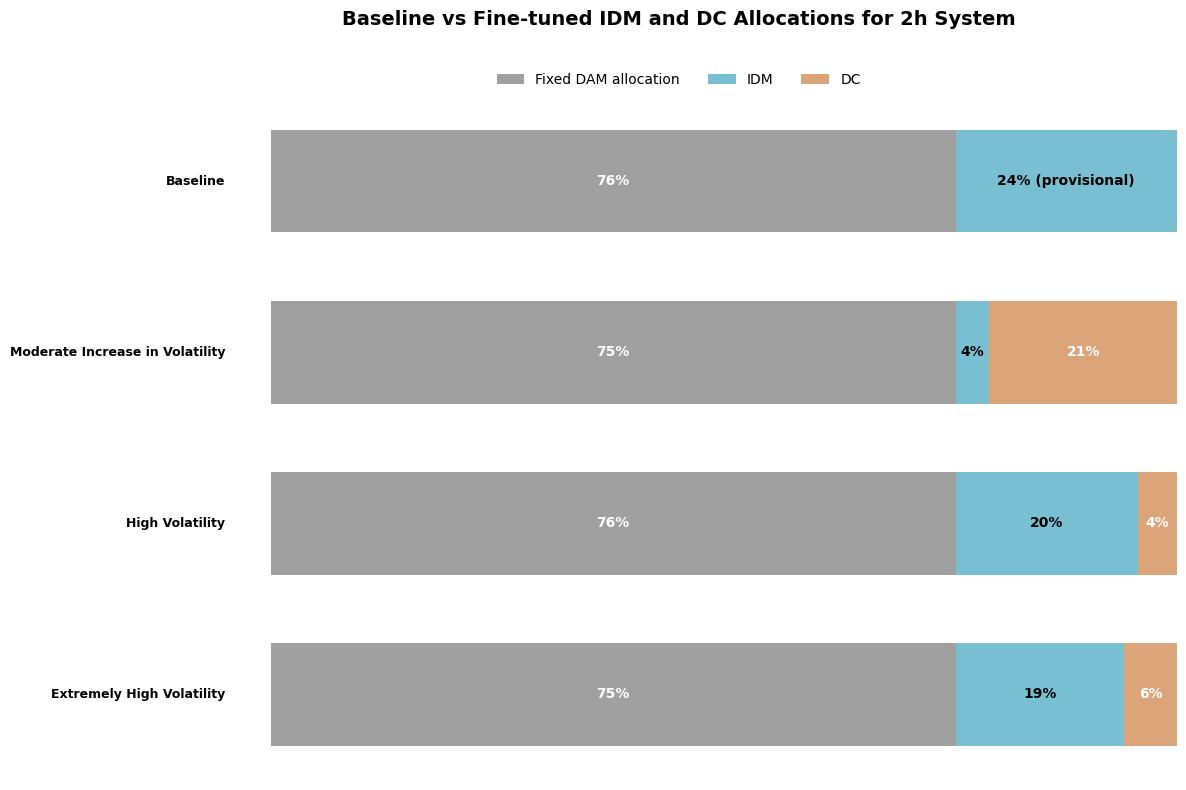

In [9]:
'''2 hour analysis'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def round_percentages(values):
    """Round percentages to sum to 100%"""
    # Handle NaN values
    if any(np.isnan(values)):
        return [0] * len(values)
    
    # Convert to percentages and round
    percentages = [v * 100 for v in values]
    rounded = [round(p) for p in percentages]
    
    # Adjust for rounding errors
    diff = 100 - sum(rounded)
    if diff != 0:
        # Find the value with largest fractional part to adjust
        fractional_parts = [p - round(p) for p in percentages]
        if diff > 0:
            # Need to add - find largest positive fractional part
            max_idx = fractional_parts.index(max(fractional_parts))
            rounded[max_idx] += diff
        else:
            # Need to subtract - find largest negative fractional part  
            min_idx = fractional_parts.index(min(fractional_parts))
            rounded[min_idx] += diff
    
    return rounded

# Load data and calculate duration
data_2024 = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Figure_12_Model_Outputs/figure_12_2024.csv')
# Filter for 2-hour duration and risk_aversion = 3
data_2h = data_2024[(data_2024['energy_mwh'] / data_2024['power_mw'] == 2.0) & (data_2024['risk_aversion'] == 3.0)]

# Get allocation data
baseline_dam = data_2h['baseline_dam_weight'].mean()
baseline_idm = data_2h['baseline_idm_weight'].mean()
baseline_dc = data_2h['baseline_dc_weight'].mean()

# Scenario allocations (scaled to remaining capacity) - reordered to 2023, 2021, 2022
remaining_cap = 1 - baseline_dam
scenarios = ['2023', '2021', '2022']
scenario_labels = ['Moderate Increase in Volatility', 'High Volatility', 'Extremely High Volatility']
scenario_data = {}

for scenario in scenarios:
    idm_weight = data_2h[f'updated_{scenario}_idm_weight'].mean() * remaining_cap
    dc_weight = data_2h[f'updated_{scenario}_dc_weight'].mean() * remaining_cap
    scenario_data[scenario] = {'IDM': idm_weight, 'DC': dc_weight}

# Create figure with better proportions
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Original colors from EDA for D* price level
base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
light_colors = {'DAM': '#8fb3d9', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
colors_grey = {'DAM': '#888888'}  # Grey for all DAM allocations

# Define separate y positions for baseline and cases
baseline_y = 0.7
case_positions = [0.5, 0.3, 0.1]  # Separate from baseline
bar_height = 0.12

# Baseline bar - DAM now in grey as well
ax.barh(baseline_y, baseline_dam, bar_height, left=0, color=colors_grey['DAM'], alpha=0.8, label='Fixed DAM allocation')
ax.barh(baseline_y, baseline_idm, bar_height, left=baseline_dam, color=light_colors['IDM'], alpha=0.8, label='IDM')
ax.barh(baseline_y, baseline_dc, bar_height, left=baseline_dam+baseline_idm, color=light_colors['DC'], alpha=0.8, label='DC')

# Round baseline percentages to sum to 100%
baseline_values = [baseline_dam, baseline_idm, baseline_dc]
baseline_rounded = round_percentages(baseline_values)

# Add percentage labels to baseline (skip if 0%) with "(provisional)" for IDM and DC
if baseline_rounded[0] > 5:  # Show if > 5%
    ax.text(baseline_dam/2, baseline_y, f'{baseline_rounded[0]}%', ha='center', va='center', fontweight='bold', color='white', fontsize=10)
if baseline_rounded[1] > 1:  # Show if > 1%
    ax.text(baseline_dam + baseline_idm/2, baseline_y, f'{baseline_rounded[1]}% (provisional)', ha='center', va='center', fontweight='bold', fontsize=10)
if baseline_rounded[2] > 1:  # Show if > 1%
    ax.text(baseline_dam + baseline_idm + baseline_dc/2, baseline_y, f'{baseline_rounded[2]}% (provisional)', ha='center', va='center', fontweight='bold', fontsize=10)

# Case bars (completely separate positions) - DAM in grey for scenarios
for i, (scenario, label) in enumerate(zip(scenarios, scenario_labels)):
    y_pos = case_positions[i]
    idm_val = scenario_data[scenario]['IDM']
    dc_val = scenario_data[scenario]['DC']
    
    # DAM portion (grey for scenario cases)
    ax.barh(y_pos, baseline_dam, bar_height, left=0, color=colors_grey['DAM'], alpha=0.8)
    # IDM portion (base color)
    ax.barh(y_pos, idm_val, bar_height, left=baseline_dam, color=base_colors['IDM'], alpha=0.8)
    # DC portion (base color)
    ax.barh(y_pos, dc_val, bar_height, left=baseline_dam + idm_val, color=base_colors['DC'], alpha=0.8)
    
    # Add case labels on the left with new scenario labels
    ax.text(-0.05, y_pos, label, ha='right', va='center', fontweight='bold', fontsize=9)
    
    # Round case percentages to sum to 100%
    case_values = [baseline_dam, idm_val, dc_val]
    case_rounded = round_percentages(case_values)
    
    # Add percentage labels (skip 0% labels)
    if case_rounded[0] > 5:  # Show if > 5%
        ax.text(baseline_dam/2, y_pos, f'{case_rounded[0]}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    if case_rounded[1] > 1:  # Only show if > 1%
        ax.text(baseline_dam + idm_val/2, y_pos, f'{case_rounded[1]}%', ha='center', va='center', fontsize=10, fontweight='bold')
    if case_rounded[2] > 1:  # Only show if > 1%
        ax.text(baseline_dam + idm_val + dc_val/2, y_pos, f'{case_rounded[2]}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Add baseline label
ax.text(-0.05, baseline_y, 'Baseline', ha='right', va='center', fontweight='bold', fontsize=9)

# Clean formatting
ax.set_xlim(-0.1, 1)
ax.set_ylim(0, 0.85)  # Adjusted for new baseline position
ax.set_title('Baseline vs Fine-tuned IDM and DC Allocations for 2h System', fontsize=14, fontweight='bold', pad=20)

# Remove all axes
ax.set_xticks([])
ax.set_yticks([])

# Add legend positioned closer to title but further from bars
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, frameon=False)

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()